## Q-learning with ORF

**Algorithm: Q-learning with shallow function approximator**

---

Initialize replay memory D to capacity N

Initialize action-value function Q with random weights

**for** episode = 1 to M **do**

&nbsp;&nbsp;&nbsp;&nbsp; Initialize sequence $s_{1} = \{x_{1}\}$ and preprocessed sequence $\phi_{1} = \phi(s_{1})$

&nbsp;&nbsp;&nbsp;&nbsp; **for** t = 1 to T **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $a_{t} = \begin{cases} \max_{a}Q(\phi(s_{t}), a; \theta)&\text{with probability } 1-\epsilon \\ \text{random action }&\text{with probability } \epsilon \end{cases}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Execute action $a_{t}$ and observe reward $r_{t}$ and image $x_{t+1}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $s_{t+1}=s_{t}$, and preprocess $\phi_{t+1} = \phi(s_{t+1})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Store transition ($\phi_{t}, a_{t}, r_{t}, \phi_{t+1}$) in D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample random minibatch of transitions ($\phi_{j}, a_{j}, r_{j}, \phi_{j+1}$) from D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $y_{j} = \begin{cases} r_{j}&\text{for terminal } \phi_{j+1} \\ r_{j} + \gamma \max_{a'} Q(\phi_{j+1}, a'; \theta)&\text{for non-terminal } \phi_{j+1} \end{cases}$


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Fit the approximator with ($\phi_{j}$,  $y_{j}$)

&nbsp;&nbsp;&nbsp;&nbsp; **end for**

**end for**

---

s = state, 

a = current action, 

a' = action for the next state, 

$\theta$ = parameters for the function approximator, 

$Q(s,a;\theta)$: action-value function estimated by a function approximator



In [1]:
import gym
import random
import pickle
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import os.path
import copy
from PIL import Image
# from sklearn.multioutput import MultiOutputRegressor
# from lightgbm import LGBMRegressor
import numpy as np
import time
import datetime
import multiprocessing

In [2]:
import ORF as ORF

In [3]:
class ORF_DQN(): 
    
    def __init__(self, n_state, n_action, replay_size):
        self.n_action = n_action
        self.a_model = {} # to build RF for each action
        self.a_params = {a: {'minSamples': replay_size*2, 'minGain': 0.1, 'xrng': None, 'maxDepth': 30} for a in range(n_action)}
        self.isFit = False
    
    def predict(self, s):            
        # s: (4,) array (for cartpole)
        
        preds = [self.a_model[a].predict(s) for a in range(self.n_action)]
        # print(preds)
        return preds

    def gen_epsilon_greedy_policy(self, epsilon, n_action):
        
        def policy_function(state):
            # state: (4,) array
            ran = "_"
            q_values =[0.0, 0.0]
            if np.random.uniform(0,1) < epsilon:
                ran = "Random"
                return([random.randint(0, n_action - 1), ran, q_values])
            else:
                if self.isFit == True:
                    ran = "Model"
                    q_values = self.predict(state) # (1,2) array
                    # print(q_values)
                else: 
                    ran = "Random_notFit"
                    return([random.randint(0, n_action - 1), ran, q_values])
                    # print("passed random.randint")
            return([np.argmax(q_values), ran, q_values])# int
        
        return policy_function


    def replay(self, memory, replay_size, gamma):
        if len(memory) == replay_size: # Build initial models
            
            for a in range(self.n_action):
                self.a_params[a]['xrng'] = ORF.dataRange([v[0] for v in memory if v[1] == a])
                self.a_model[a] = ORF.ORF(self.a_params[a], numTrees=30) # Fit initial RFs for each action            
            
        if len(memory) >= replay_size: # When the memory size exceeds the replay_size, start updating the RFs
            
            replay_data = random.sample(memory, replay_size) # replay_data consists of [state, action, next_state, reward, is_done]
            for state, action, next_state, reward, is_done in replay_data:
                
                q_values = self.predict(state) # (, n_actions)
                q_values[action] = reward + gamma * np.max(self.predict(next_state)) if is_done == False else -1000 * reward
                
                # Update the RF for the action taken
                xrng = ORF.dataRange([v[0] for v in replay_data if v[1] == action])
                self.a_model[action].update(state, q_values[action])    
            self.isFit = True
            

In [4]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=0.95):
    
    for episode in tqdm(range(n_episode)):
        policy = estimator.gen_epsilon_greedy_policy(epsilon, n_action)
        state = env.reset()
        is_done = False
        i = 0
        while not is_done:
            action, ran, pred = policy(state) # integer
            next_state, reward, is_done, _ = env.step(action)
            i += 1
            # next_state: 4x1 array (for cartpole)
            # reward: integer
            # is_done: bool (True/False)
            
            total_reward_episode[episode] += reward
            
            ep[episode].append((i, state, ran, action))
            memory.append((state, action, next_state, reward, is_done))
            
            if is_done:
                break
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        epsilon = np.max([epsilon * epsilon_decay, 0.01])
        # print(epsilon)

100%|██████████| 50/50 [07:36<00:00,  9.13s/it]
learning duration = 456  seconds
mean reward =  85.72
max reward =  214.0


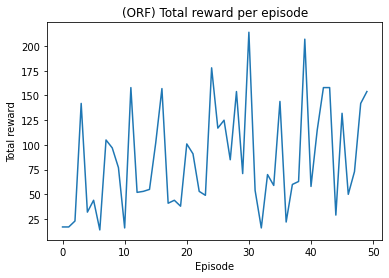

<Figure size 432x288 with 0 Axes>

In [6]:
backup_file_name = "ORF_CartPole_" + time.strftime("%y%m%d") + "_1"

env = gym.envs.make("CartPole-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n

memory = deque(maxlen=10000)
n_episode = 50
replay_size = 20

dqn = ORF_DQN(n_state, n_action, replay_size) 

total_reward_episode = [0] * n_episode

start = time.time()

ep = {i: [] for i in range(n_episode)}

q_learning(env, dqn, n_episode, replay_size, gamma=1.0, epsilon=0.5, epsilon_decay=0.99) # runs the alg

end = time.time()
duration = int(end - start)

img_file = backup_file_name + ".jpg"
print("learning duration =", duration, " seconds")
print("mean reward = ", np.mean(total_reward_episode))
print("max reward = ", max(total_reward_episode))
plt.plot(total_reward_episode)
plt.title("(ORF) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()
plt.savefig(fname = img_file)

In [6]:
# To back-up the work
backup_file = backup_file_name + ".p"
backup_check = os.path.isfile(backup_file)

myEnv = dict()
myEnv["t_r_e"] = total_reward_episode
myEnv["duration"] = duration
myEnv["episode_details"] = ep
# myEnv["ORF_params"] = params

with open(backup_file, "wb") as file:
    pickle.dump(myEnv, file)